In [ ]:
#Gerekli kütüphaneler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Eğitim ve geçerleme dizinleri
train_dataset_path = '/content/drive/MyDrive/tehdit/train'
validation_dataset_path = '/content/drive/MyDrive/tehdit/val'

In [ ]:
#Veri artırımı için değişken belirleme
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [ ]:
#Veri artırımı Data Augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)


validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1752 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
#Sınıfların etiket numarası
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Eğitim ve Geçerleme kümelerinde bulunan verilerin etiket değerleri\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Eğitim ve Geçerleme kümelerinde bulunan verilerin etiket değerleri

0 : bicak
1 : silah


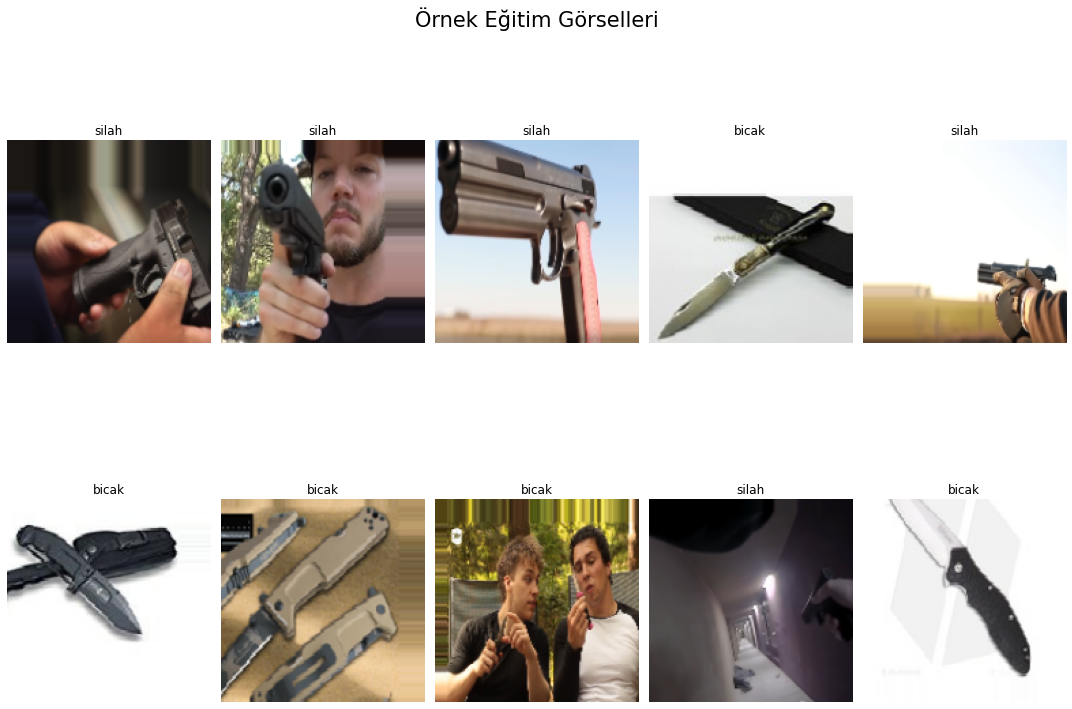

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Örnek Eğitim Görselleri", fontsize=21)
plt.show()

In [ ]:
#Model tanımlaması keras ile sıralı model oluşturma
def create_model():
    model = Sequential([
                        
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
    ])
    
    return model

In [ ]:
cnn_model = create_model()

In [ ]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

In [ ]:
#Eğitim esnasında takip ettiğiniz değerde belirleyeceğiniz adım — epoch — boyunca iyileşme yoksa
#Öğrenme hızını sizin belirleyeceğiniz bir katsayıyla çarparak küçültüyor. 5 adım boyunca iyileşme olmazsa 0.1 ile çarparak değiştiriyor

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [ ]:
#ADAM yani Adaptif Moment Tahmini

optimizer = Adam(learning_rate=0.001)

In [ ]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(train_generator,
                        epochs=50,
                        validation_data=validation_generator,
                        verbose=2,
                        callbacks=[reduce_lr])

Epoch 1/50
55/55 - 211s - loss: 1.9101 - accuracy: 0.6849 - val_loss: 1.6523 - val_accuracy: 0.5167 - lr: 0.0010 - 211s/epoch - 4s/step
Epoch 2/50
55/55 - 40s - loss: 1.7886 - accuracy: 0.7026 - val_loss: 1.1531 - val_accuracy: 0.3833 - lr: 0.0010 - 40s/epoch - 723ms/step
Epoch 3/50
55/55 - 39s - loss: 1.3287 - accuracy: 0.7009 - val_loss: 1.2677 - val_accuracy: 0.6000 - lr: 0.0010 - 39s/epoch - 717ms/step
Epoch 4/50
55/55 - 39s - loss: 0.9299 - accuracy: 0.7237 - val_loss: 0.4436 - val_accuracy: 0.8667 - lr: 0.0010 - 39s/epoch - 714ms/step
Epoch 5/50
55/55 - 40s - loss: 0.7776 - accuracy: 0.7626 - val_loss: 0.5635 - val_accuracy: 0.5333 - lr: 0.0010 - 40s/epoch - 721ms/step
Epoch 6/50
55/55 - 41s - loss: 0.6733 - accuracy: 0.7643 - val_loss: 0.6682 - val_accuracy: 0.4667 - lr: 0.0010 - 41s/epoch - 737ms/step
Epoch 7/50
55/55 - 41s - loss: 0.5084 - accuracy: 0.7957 - val_loss: 0.6362 - val_accuracy: 0.5833 - lr: 0.0010 - 41s/epoch - 741ms/step
Epoch 8/50
55/55 - 41s - loss: 0.4581 - ac

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

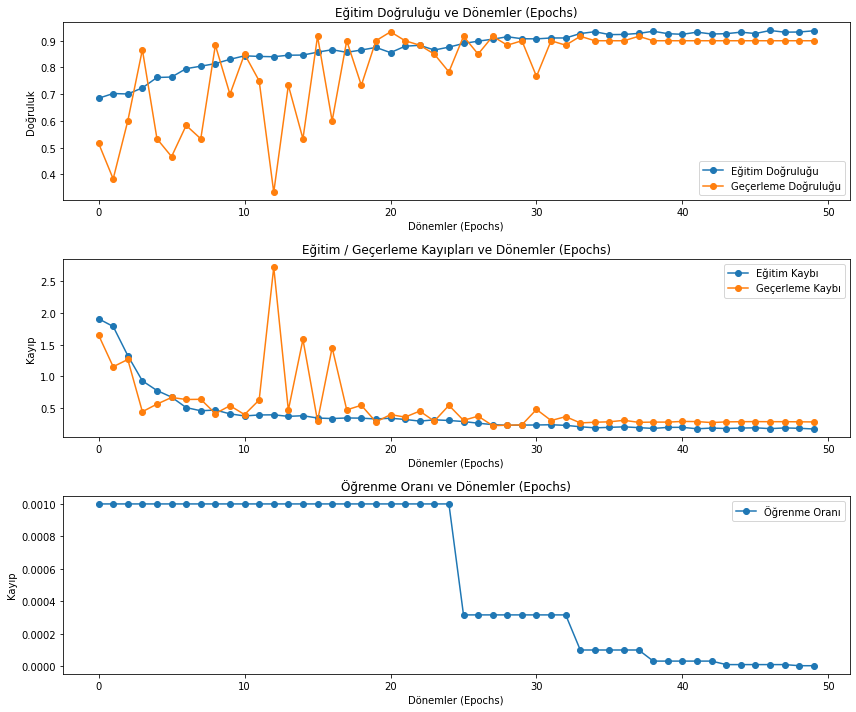

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Eğitim Doğruluğu ve Dönemler (Epochs)')
ax[0].plot(train_accuracy, 'o-', label='Eğitim Doğruluğu')
ax[0].plot(val_accuracy, 'o-', label='Geçerleme Doğruluğu')
ax[0].set_xlabel('Dönemler (Epochs)')
ax[0].set_ylabel('Doğruluk')
ax[0].legend(loc='En iyi')

ax[1].set_title('Eğitim / Geçerleme Kayıpları ve Dönemler (Epochs)')
ax[1].plot(train_loss, 'o-', label='Eğitim Kaybı')
ax[1].plot(val_loss, 'o-', label='Geçerleme Kaybı')
ax[1].set_xlabel('Dönemler (Epochs)')
ax[1].set_ylabel('Kayıp')
ax[1].legend(loc='En iyi')

ax[2].set_title('Öğrenme Oranı ve Dönemler (Epochs)')
ax[2].plot(learning_rate, 'o-', label='Öğrenme Oranı')
ax[2].set_xlabel('Dönemler (Epochs)')
ax[2].set_ylabel('Kayıp')
ax[2].legend(loc='En iyi')

plt.tight_layout()
plt.show()

In [ ]:
test_dataset = '/content/drive/MyDrive/tehdit/test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 72 images belonging to 2 classes.


In [ ]:
predictions = cnn_model.predict(test_generator)

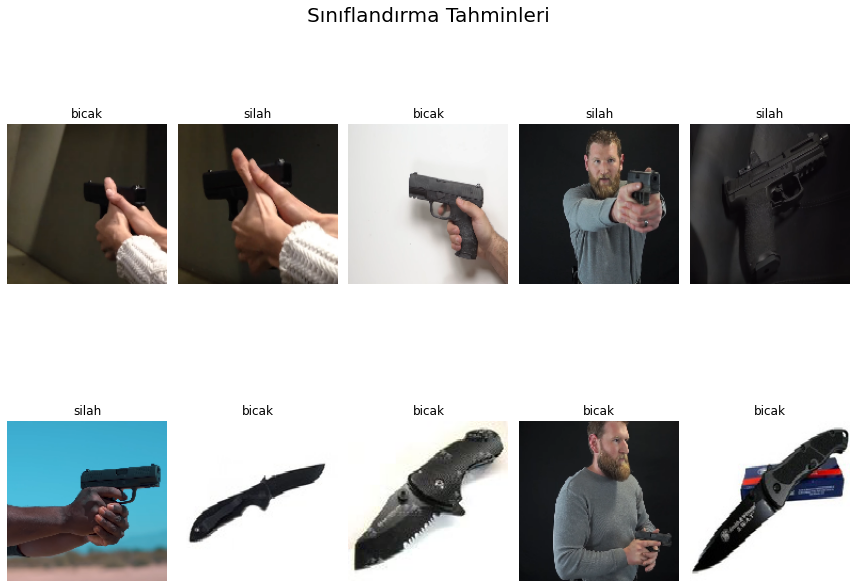

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sınıflandırma Tahminleri", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

3/3 [==============================] - 1s 294ms/step - loss: 0.1750 - accuracy: 0.9167


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.17497506737709045
Test Accuracy: 0.9166666865348816


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

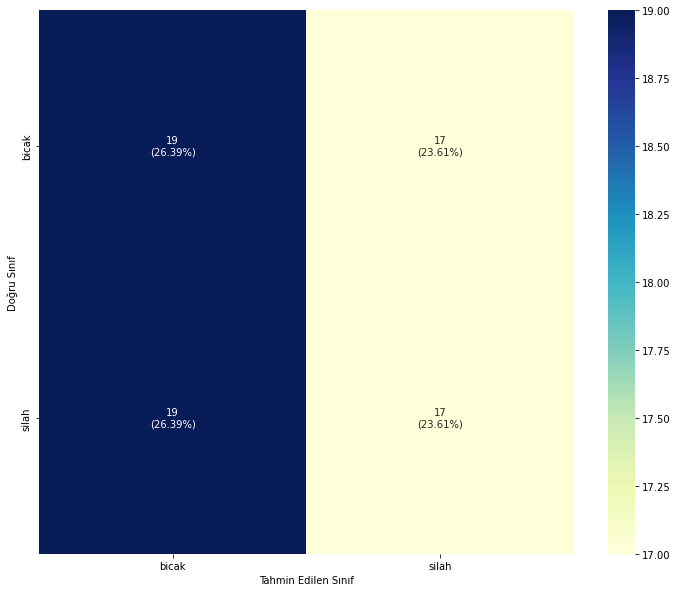

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Doğru Sınıf')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

       bicak       0.50      0.53      0.51        36
       silah       0.50      0.47      0.49        36

    accuracy                           0.50        72
   macro avg       0.50      0.50      0.50        72
weighted avg       0.50      0.50      0.50        72



In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

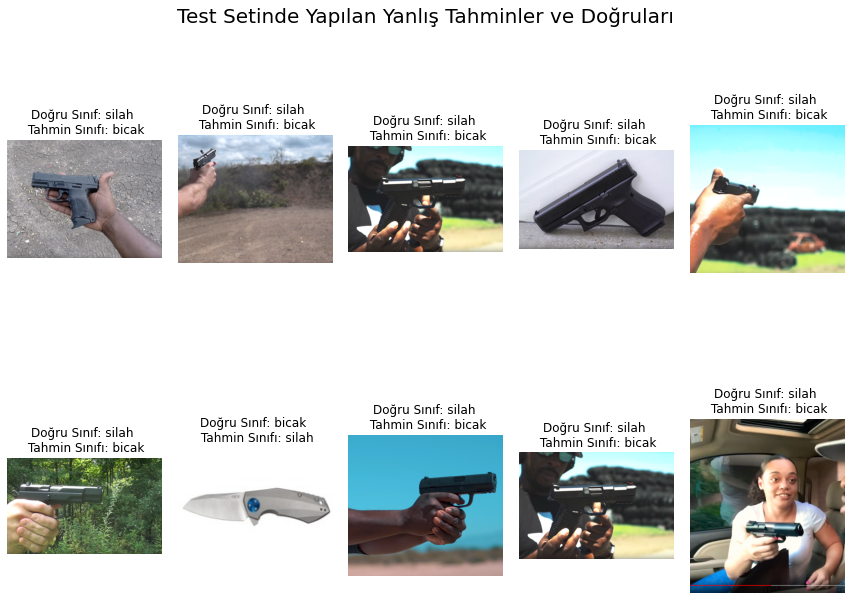

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"Doğru Sınıf: {true_label} \n Tahmin Sınıfı: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Test Setinde Yapılan Yanlış Tahminler ve Doğruları', fontsize=20)
plt.show()